# Data Exploration: Initial Data Impressions
Let's take a look at the CSV and parquet files so we know what we're working with!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Helpers
# param: dfs has the shape (title, df)
def print_dfs(dfs):
    for title, df in dfs:
        print(title)
        print(df.head())
        print()

In [5]:
path = Path('./data')
sorted(os.listdir(path))

['bengaliai-cv19.zip',
 'class_map.csv',
 'mini-train',
 'mini-train.csv',
 'models',
 'sample_submission.csv',
 'test',
 'test.csv',
 'test_image_data_0.parquet',
 'test_image_data_1.parquet',
 'test_image_data_2.parquet',
 'test_image_data_3.parquet',
 'train',
 'train.csv',
 'train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet']

In [6]:
train_csv = pd.read_csv(path/'train.csv')
test_csv = pd.read_csv(path/'test.csv')
class_map_csv = pd.read_csv(path/'class_map.csv')
sample_submission_csv = pd.read_csv(path/'sample_submission.csv')

print_dfs([
    ('Train CSV', train_csv),
    ('Test CSV', test_csv),
    ('Class Map CSV', class_map_csv),
    ('Sample Submission CSV', sample_submission_csv),
])

Train CSV
  image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

Test CSV
                       row_id image_id            component
0  Test_0_consonant_diacritic   Test_0  consonant_diacritic
1        Test_0_grapheme_root   Test_0        grapheme_root
2      Test_0_vowel_diacritic   Test_0      vowel_diacritic
3  Test_1_consonant_diacritic   Test_1  consonant_diacritic
4        Test_1_grapheme_root   Test_1        grapheme_root

Class Map CSV
  component_type  label component
0  grapheme_root      0         ং
1  grapheme_root      1         ঃ
2  grapheme_root      2         অ
3  grapheme_root      3        

In [8]:
# How many train and test images?
print('Num training images:\t', len(train_csv.image_id.unique()))
print('Num test images:\t', len(test_csv.image_id.unique()))

Num training images:	 200840
Num test images:	 12


There's so few test images because kaggle limits how many can be downloaded. Instead, we'll have to train the model, save the weights, then load the model onto kaggle. Finally we'll make predictions on the test set there which should contain as many images as the training set.

## Break up Class Map into 3 pieces: 
- Grapheme Root
- Vowel Diacritic
- Consonant Diacritic

In [9]:
class_map_csv.component_type.unique()

array(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'],
      dtype=object)

In [10]:
grapheme_root = class_map_csv[class_map_csv.component_type == 'grapheme_root']
vowel_diacritic = class_map_csv[class_map_csv.component_type == 'vowel_diacritic']
consonant_diacritic = class_map_csv[class_map_csv.component_type == 'consonant_diacritic']

print_dfs([
    ('Grapheme Root', grapheme_root.head()),
    ('Vowel Diacritic', vowel_diacritic.head()),
    ('Consonant Diacritic', consonant_diacritic.head()),
])

Grapheme Root
  component_type  label component
0  grapheme_root      0         ং
1  grapheme_root      1         ঃ
2  grapheme_root      2         অ
3  grapheme_root      3         আ
4  grapheme_root      4         ই

Vowel Diacritic
      component_type  label component
168  vowel_diacritic      0         0
169  vowel_diacritic      1         া
170  vowel_diacritic      2         ি
171  vowel_diacritic      3         ী
172  vowel_diacritic      4         ু

Consonant Diacritic
          component_type  label component
179  consonant_diacritic      0         0
180  consonant_diacritic      1         ঁ
181  consonant_diacritic      2        র্
182  consonant_diacritic      3       র্য
183  consonant_diacritic      4        ্য



In [11]:
print('Num Grapheme Root:\t', len(grapheme_root.label.unique()))
print('Num Vowel Diacritic:\t', len(vowel_diacritic.label.unique()))
print('Num Consonant Diacritic:', len(consonant_diacritic.label.unique()))

Num Grapheme Root:	 168
Num Vowel Diacritic:	 11
Num Consonant Diacritic: 7


## How many training images do not have a diacritic?
(I believe all should have a grapheme root, and we'll confirm that too)

In [12]:
# Ensure all images have a grapheme root
data_w_no_grapheme_root = train_csv[train_csv.grapheme_root.isna()]
data_w_no_grapheme = train_csv[train_csv.grapheme.isna()]

assert len(data_w_no_grapheme_root) == 0
assert len(data_w_no_grapheme) == 0

In [13]:
# How many images do not have a vowel diacritic?
data_w_no_vowel_dia = train_csv[train_csv.vowel_diacritic.isna()]
len(data_w_no_vowel_dia)

0

In [14]:
# How many images do not have a consonant diacritic?
data_w_no_consonant_dia = train_csv[train_csv.consonant_diacritic.isna()]
len(data_w_no_consonant_dia)

0

## How are the class_maps distributed?
We may end up with many more examples of one class than another which will make training more difficult.

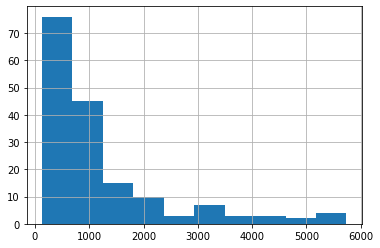

In [16]:
train_csv.grapheme_root.value_counts().hist()

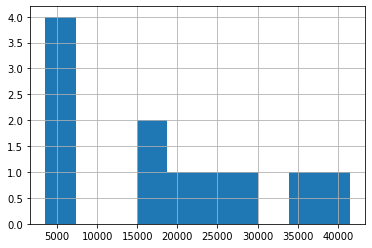

In [17]:
train_csv.vowel_diacritic.value_counts().hist()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb5bd34c18>, 0    125278
 2     23465
 5     21397
 4     21270
 1      7424
 6      1387
 3       619
 Name: consonant_diacritic, dtype: int64)

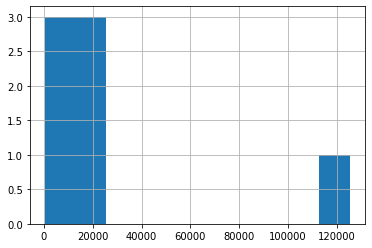

In [64]:
consonant_counts = train_csv.consonant_diacritic.value_counts()

consonant_counts.hist(), consonant_counts.head(10)

## All 3 of the graphs show how the value counts are distributed
In the grapheme graph, we see most graphemes are used ~0-1500 times while some are used ~2000-5500 times. This makes predicting the ones used less often a bit more difficult.

However, we may be able to use some data augmentation to artificially create more training data.

Another thing to note is the gap in the consonants counts. There are 3 consonant diacritics used 20,000+ times, then there's a significant drop off rate for the other consonants. Again, this may make training more difficult.

## How many unique graphemes are there?

In [66]:
len(train_csv.grapheme.unique())

1295

## How are graphemes and grapheme roots related?

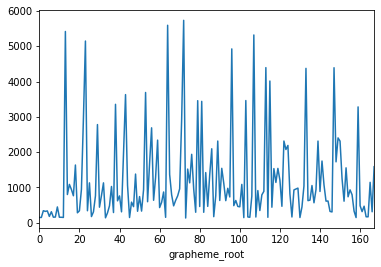

In [85]:
train_csv[['grapheme_root', 'grapheme']].groupby('grapheme_root').count()['grapheme'].plot()

# Summary

- Num. of images:
  - train: **200,840**
  - test: **12**
- This means there will be **36 rows** in the submission file because each test image gets 3 rows of output:
  - [grapheme root](https://en.wikipedia.org/wiki/Grapheme)
  - [vowel diacritic](https://en.wikipedia.org/wiki/Diacritic)
  - [consonant diacritic](https://en.wikipedia.org/wiki/Diacritic)
- Num unique items in class map:
  - grapheme root: 168
  - vowel diacritic: 11
  - consonant diacritic: 7
- Vowel/Consonant diacritic of 0 means *there's no diacritic*
- There are 1295 unique graphemes but only 168 unique grapheme roots
  
# Other Notes
- A [diacritic](https://en.wikipedia.org/wiki/Diacritic) is an accent put onto a letter. One purpose is to change how the word is pronounced. 